In [1]:
import numpy as np
import arms
from non_stochastic_bandit import produce_loss_sequence, EXP3, EXP3_IX, EXP3_P
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [4]:
def compute_percentage_draws(targets, draws):
    pers = [[0] for j in range(len(targets))]
    T = len(draws)
    for i in range(T):
        for j in range(len(targets)):
            if draws[i] == targets[j]:
                pers[j].append(pers[j][-1]+1)
            else:
                pers[j].append(pers[j][-1])
    for j in range(len(targets)):
        pers[j] = np.array(pers[j][1:]) / np.arange(1, T+1)
    return pers

In [2]:
random_state = np.random.randint(1, 312414)

delta = 0.1
# Bernoulli loss arm
arm1 = arms.ArmBernoulli(0.50, random_state=random_state)
arm2 = arms.ArmBernoulli(0.50, random_state=random_state)
arm3 = arms.ArmBernoulli(0.50, random_state=random_state)
arm4 = arms.ArmBernoulli(0.50, random_state=random_state)
arm5 = arms.ArmBernoulli(0.50, random_state=random_state)
arm6 = arms.ArmBernoulli(0.50, random_state=random_state)
arm7 = arms.ArmBernoulli(0.50, random_state=random_state)
arm8 = arms.ArmBernoulli(0.50, random_state=random_state)
arm9 = arms.ArmBernoulli(0.50-delta, random_state=random_state)
arm10_1 = arms.ArmBernoulli(0.50+delta, random_state=random_state)
arm10_2 = arms.ArmBernoulli(0.50-4*delta, random_state=random_state)

arm11 = arms.ArmPieceConstant(mean=0.5, delta=0.2, fre=500, random_state=0)
arm12 = arms.ArmPieceIncrease(lower=0, upper=1, delta=0.1, prob=0.001, random_state=0)
arm13 = arms.ArmPieceDecrease(lower=0, upper=1, delta=0.1, prob=0.001, random_state=0)

arm14 = arms.ArmBeta(a=2, b=2, random_state=0)
arm15 = arms.ArmBeta(a=0.5, b=0.5, random_state=0)

MAB1 = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9, arm10_1, arm11, arm12, arm13, arm14, arm15]
MAB2 = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9, arm10_2, arm11, arm12, arm13, arm14, arm15]

#reward arm
#arm9_ = arms.ArmBernoulli(0.50+delta, random_state=random_state)
#arm10_1_ = arms.ArmBernoulli(0.50-delta, random_state=random_state)
#arm10_2_ = arms.ArmBernoulli(0.50+4*delta, random_state=random_state)

#MAB1_ = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9_, arm10_1_]
#MAB2_ = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9_, arm10_2_]

# bandit : set of arms

T = 1e4
K = len(MAB1)
change_time = int(T/2)

loss_sequence = produce_loss_sequence(env=MAB1, T=T, env_change=True, new_env=MAB2, change_time=change_time)

single_global_best = np.min(np.sum(loss_sequence, axis=0))
single_global_best_2 = np.min(np.sum(loss_sequence[: int(T/2)], axis=0))

In [ ]:
etas = [10**i for i in np.linspace(-2.5, 0, 8)]
repeat = 50
regrets_ix = []
regrets_exp3 = []
regrets_exp3p = []
#regrets = []
#regrets_2 = []
for eta in etas:
    tmp_ix = [[], []]
    tmp_exp3 = [[], []]
    tmp_exp3p = [[], []]
    #gamma = np.min([0.6, 2*np.sqrt(0.6 * K * np.log(K) / T)])
    gamma = 0.005
    #alpha = 2 * np.sqrt(np.log(K * T / 0.01))
    #beta = 0.006
    beta = gamma / K
    for _ in range(repeat):
        _, loss = EXP3_P(loss_sequence=loss_sequence, 
                         eta=eta, 
                         gamma=gamma,
                         beta=beta,
                         T=T)
        tmp_exp3p[0].append(np.sum(loss) - single_global_best)
        tmp_exp3p[1].append(np.sum(loss[:change_time]) - single_global_best_2)

        _, loss = EXP3(loss_sequence=loss_sequence, 
                 eta=eta, 
                 gamma=gamma,
                 T=T)
        tmp_exp3[0].append(np.sum(loss) - single_global_best)
        tmp_exp3[1].append(np.sum(loss[:change_time]) - single_global_best_2)

        _, loss = EXP3_IX(loss_sequence=loss_sequence, 
                 eta=eta, 
                 gamma=gamma,
                 T=T)
        tmp_ix[0].append(np.sum(loss) - single_global_best)
        tmp_ix[1].append(np.sum(loss[:change_time]) - single_global_best_2)
    #print('eta: %0.3f, regret: %f' % (eta, np.mean(tmp)))
    regrets_ix.append(tmp_ix)
    regrets_exp3.append(tmp_exp3)
    regrets_exp3p.append(tmp_exp3p)

regrets_ix = np.array(regrets_ix)
regrets_exp3p = np.array(regrets_exp3p)
regrets_exp3 = np.array(regrets_exp3)

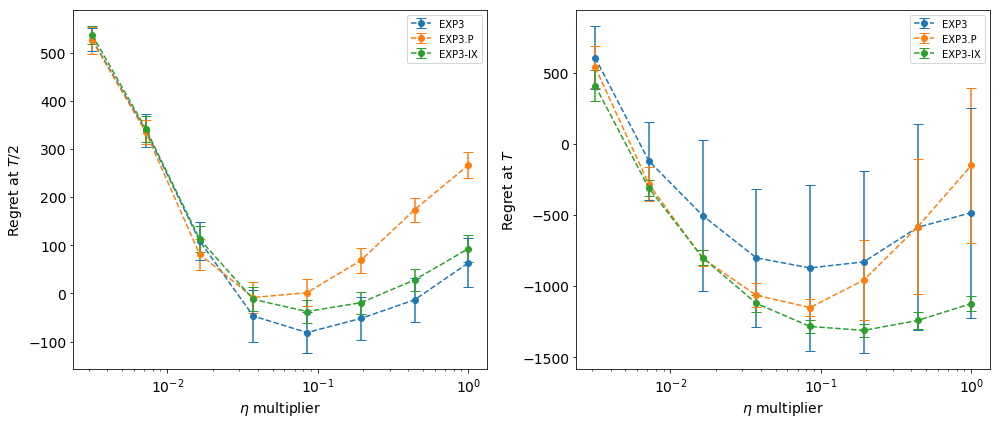

In [5]:
std_ix = np.std(regrets_ix, axis=2).T
mean_ix = np.mean(regrets_ix, axis=2).T

std_exp3 = np.std(regrets_exp3, axis=2).T
mean_exp3 = np.mean(regrets_exp3, axis=2).T

std_exp3p = np.std(regrets_exp3p, axis=2).T
mean_exp3p = np.mean(regrets_exp3p, axis=2).T

means = [mean_exp3, mean_exp3p, mean_ix]
stds = [std_exp3, std_exp3p, std_ix]

algos = ['EXP3', 'EXP3.P', 'EXP3-IX']
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 6))
for i in range(len(algos)):
    ax1.errorbar(etas, means[i][1], yerr=stds[i][1], fmt='--o', label=algos[i])
ax1.set_xscale('log')
ax1.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax1.set_ylabel(r'Regret at $T/2$', fontsize=14)
ax1.legend()

for i in range(len(algos)):
    ax2.errorbar(etas, means[i][0], yerr=stds[i][0], fmt='--o', label=algos[i])
ax2.set_xscale('log')
ax2.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax2.set_ylabel(r'Regret at $T$', fontsize=14)
ax2.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('../../../../Desktop/images/arm15.png')
plt.show()

In [6]:
repeat = 50
draws_ix = []
draws_exp3 = []
draws_exp3p = []
#regrets = []
#regrets_2 = []
eta = etas[5]

#gamma = np.min([0.6, 2*np.sqrt(0.6 * K * np.log(K) / T)])
gamma = 0.005
#alpha = 2 * np.sqrt(np.log(K * T / 0.01))
#beta = 0.006
beta = gamma / K
for _ in range(repeat):
    draws, loss = EXP3_P(loss_sequence=loss_sequence, 
                     eta=eta, 
                     gamma=gamma,
                     beta=beta,
                     T=T)
    draws_exp3p.append(draws)

    draws, loss = EXP3(loss_sequence=loss_sequence, 
             eta=eta, 
             gamma=gamma,
             T=T)
    draws_exp3.append(draws)

    draws, loss = EXP3_IX(loss_sequence=loss_sequence, 
             eta=eta, 
             gamma=gamma,
             T=T)
    draws_ix.append(draws)

In [23]:
targets = [0, 8, 9, 10, 11, 12, 13, 14]
pers_exp3 = []
pers_exp3p = []
pers_ix = []
for i in range(repeat):
    res = np.array(compute_percentage_draws(targets=targets, draws=draws_ix[i]))
    pers_ix.append(res)
    
    res = np.array(compute_percentage_draws(targets=targets, draws=draws_exp3[i]))
    pers_exp3.append(res)
    
    res = np.array(compute_percentage_draws(targets=targets, draws=draws_exp3p[i]))
    pers_exp3p.append(res)
    
pers_exp3 = np.array(pers_exp3)
pers_exp3p = np.array(pers_exp3p)
pers_ix = np.array(pers_ix)

pers = [pers_exp3, pers_exp3p, pers_ix]
means = [np.mean(item, axis=0) for item in pers]
stds = [np.std(item, axis=0) for item in pers]

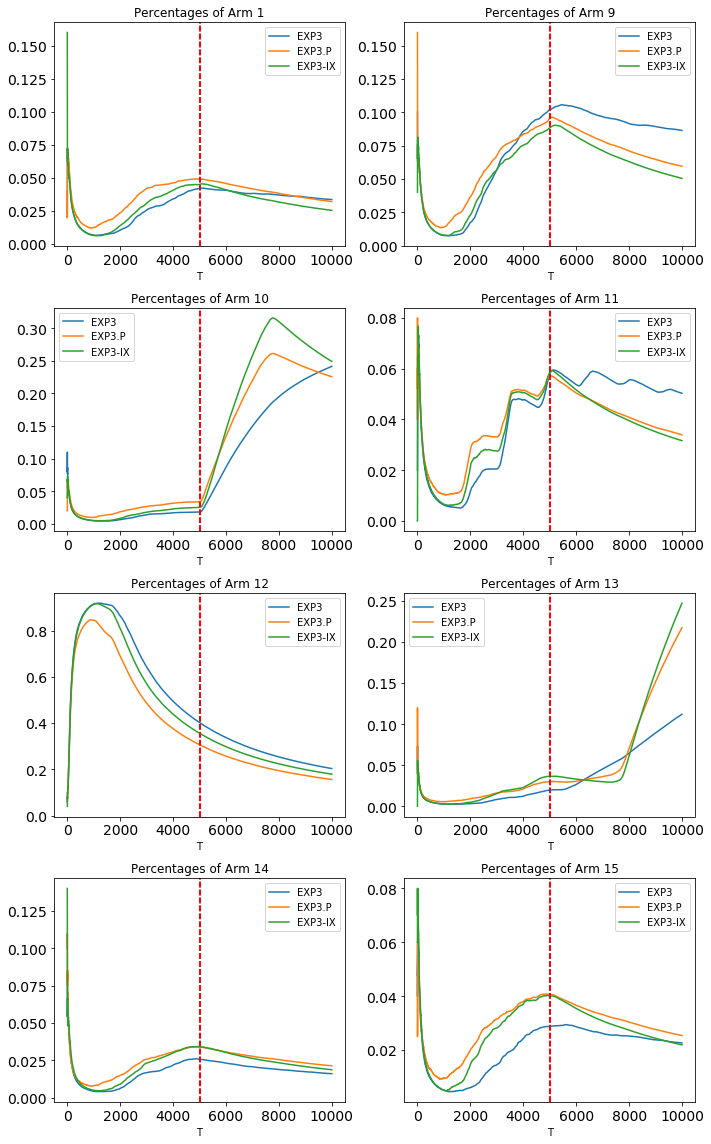

In [52]:
f, axarr = plt.subplots(4, 2, figsize=(10, 16))

for i in range(4):
    for j in range(2):
        index = i*2 + j
        for k in range(len(means)):
            axarr[i, j].plot(means[k][index], label=algos[k])
            axarr[i, j].set_title('Percentages of Arm %i' %(targets[index]+1))
            axarr[i, j].axvline(int(T/2), color='r', linestyle='--')
            axarr[i, j].set_xlabel('T')
            axarr[i, j].legend()
plt.tight_layout()
plt.savefig('../../../../Desktop/images/arm15_percent.png')
plt.show()